# HW 5. RHRNet for Audio Denoising. 

В домашней работе вы познакомитесь с задачей разделения шума и речи в одноканальном аудиосигнале.

 Работать будем с датасетами **TIMIT**: это датасет чистой речи, люди с разными диалектами американского английского читают предложения. Вторым датасетом будет датасет шумов **DEMAND**.

 Моделью денойзинга будет **[RHRNet](https://arxiv.org/ftp/arxiv/papers/1904/1904.07294.pdf)**. Общая архитектура модели напоминает **U-net**, где каждый блок представляет собой двунаправленную реккурентную сеть. Модель работает с маленькими участками аудиофайла длиной $1024$, что при частоте дискретизации $16$ kHz соответствует $16$ ms.

**Наш план**:

- Научиться работать с аудиоданными: добавлять шум к аудио с разными уровнями **SNR**
- Создать датасеты для обучения и тестирования. 
- Реализовать модель
- Реализоввать инфраструктурные функции для обучения модели
- Обучить модель
- Посмотреть результаты

Импорт необходимых библиотек :)

In [ ]:
import numpy as np
import itertools
import torch
import librosa
import math

from glob import glob
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torch.nn import functional as F
from IPython import display as ipd
from torch.utils.data import DataLoader, Dataset
import librosa.display

In [ ]:
SR = 16000
EPS = 1e-20

# 9.1 Посмотреть на данные (2 балла)

## Примеры DEMAND

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
data_root = 'gdrive/MyDrive/DEMAND'
demand_paths = glob(f"{data_root}/*.wav")

Для работы с аудио будем использовать библиотеку **librosa**. 

Так как мы все тут *эксперты* по звуку, то сразу же посмотрим спектральные характеристики представленных шумов. 

In [ ]:
audios = []
for idx in idxs:
    x, sr = librosa.load(demand_paths[idx], sr=16000)
    print(sr)
    audios.append(x)

16000
16000
16000


Воспользуйтесь функцией **librosa.dispalay.waveplot**, чтобы отрисовать амплитуды аудиозаписей на участке, соответствующем одной секунде.

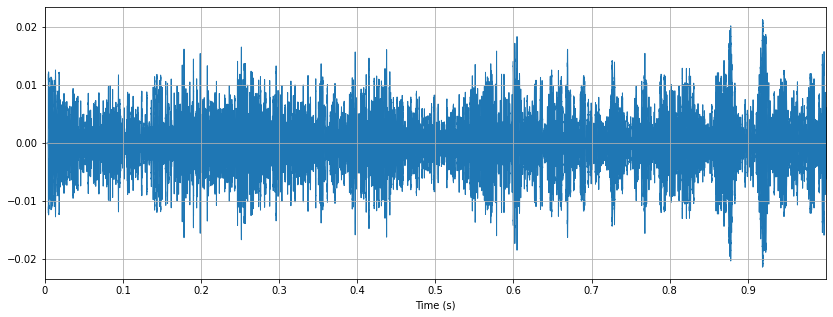

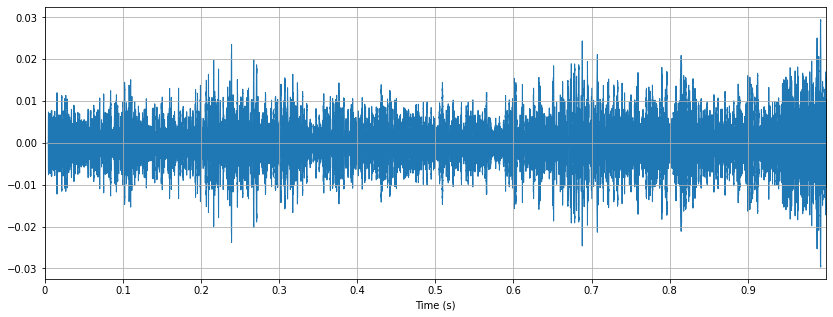

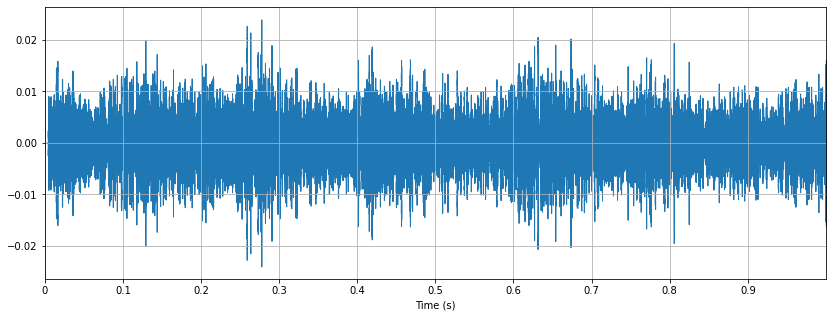

In [ ]:
import librosa.display
for x in audios:
    plt.figure(figsize=(14, 5))
    x_one_second = x[:sr]
    librosa.display.waveplot(x_one_second, sr=sr, x_axis='s')
    plt.grid()
    plt.show()

Воспользуйтесь функциями librosa.stft, librosa.amplitude_to_db, librosa.display.specshow, чтобы получить и отрисовать спектрограммы выбранных аудиозаписей.

Дополнительно, ознакомьтесь с **STFT**(short-term-fourier-transform).

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


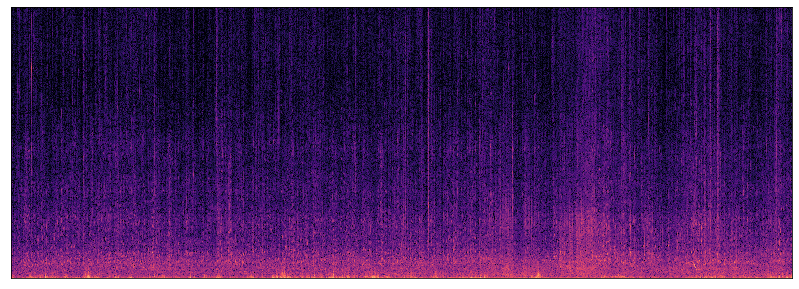

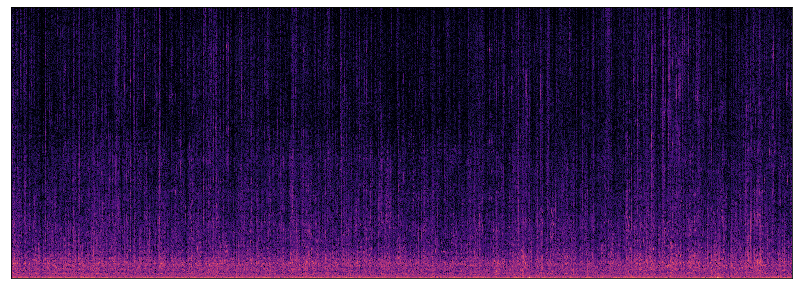

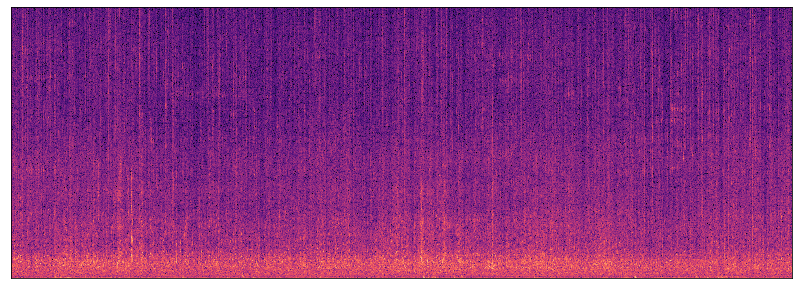

In [ ]:
for x in audios:
    plt.figure(figsize=(14, 5))
    s = librosa.stft(x)
    db = librosa.amplitude_to_db(s)
    librosa.display.specshow(db)
    plt.grid()
    plt.show()

## Примеры TIMIT

Теперь посмотрим на образцы речи, которые мы будем использовать в качестве эталонной чистой речи.

In [ ]:
data_root = 'gdrive/MyDrive'
timit_train_paths = glob(f"{data_root}/TIMIT/TRAIN/*/*/*.WAV")
timit_test_paths = glob(f"{data_root}/TIMIT/TEST/*/*/*.WAV")

In [ ]:
idxs = [0, 88, 191]

In [ ]:
audios = []
for idx in idxs:
    x, sr = librosa.load(timit_test_paths[idx], sr=16000 )
    print(sr)
    audios.append(x)

16000
16000
16000


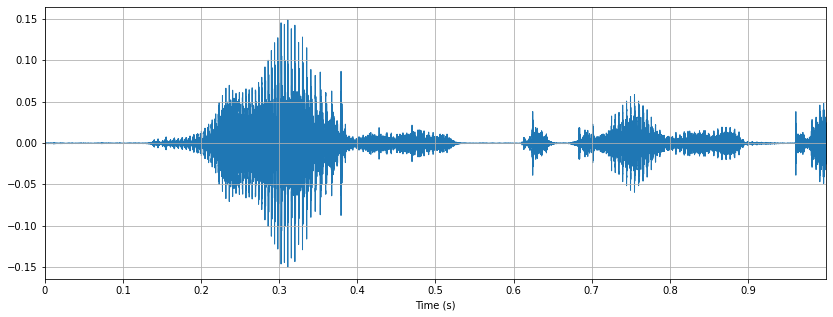

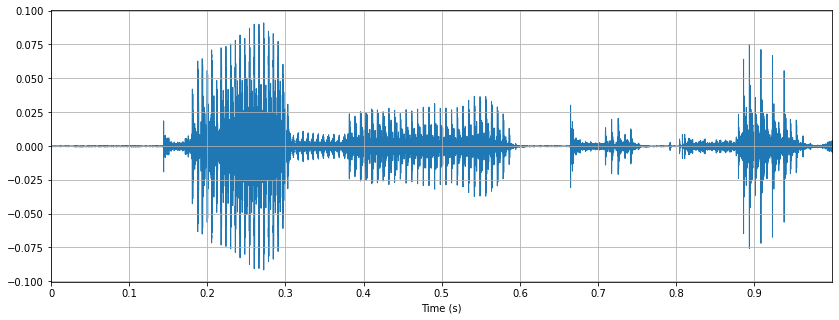

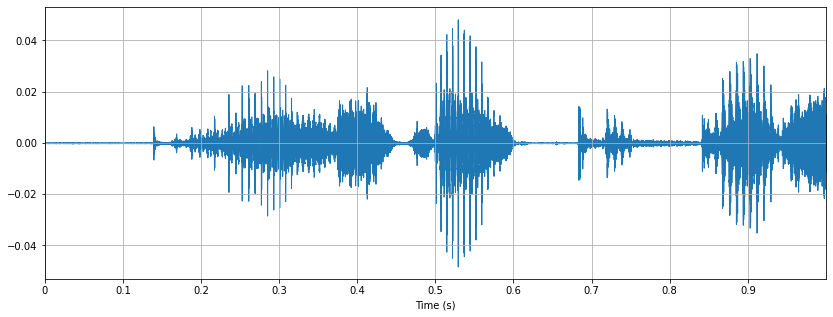

In [ ]:
for x in audios:
    plt.figure(figsize=(14, 5))
    x_one_second = x[:sr]
    librosa.display.waveplot(x_one_second, sr=sr, x_axis='s')
    plt.grid()
    plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


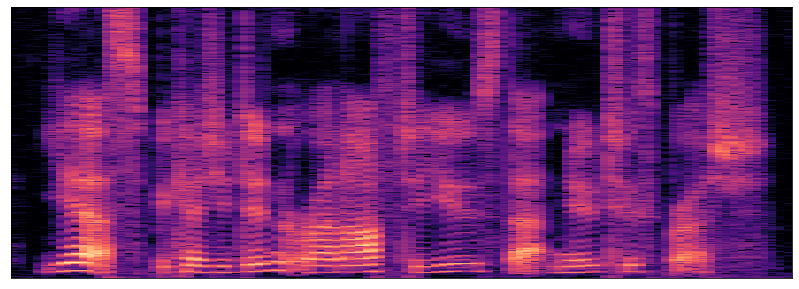

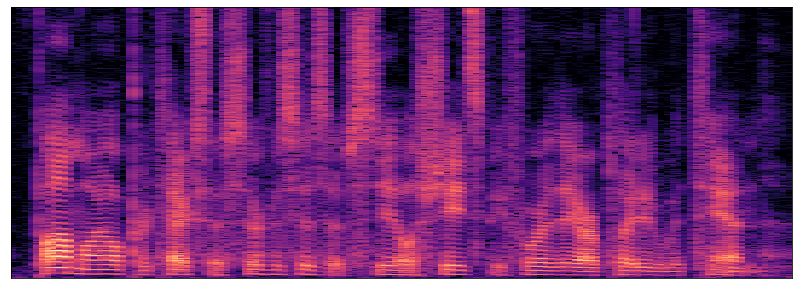

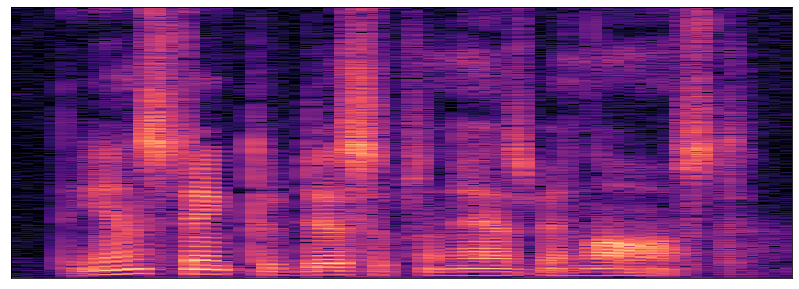

In [ ]:
for x in audios:
    plt.figure(figsize=(14, 5))
    s = librosa.stft(x)
    db = librosa.amplitude_to_db(s)
    librosa.display.specshow(db)
    plt.grid()
    plt.show()

## Слияние шума и речи (2 балла)

Нам необходимо слить аудиозаписи и шумы с заданным **[SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)**.

In [ ]:
def add_noise(clean, noise, snr):

    snr = 10**(snr / 10.0)
    alpha = np.sqrt(np.sum(clean**2) / (snr * np.sum(noise**2)))
    noisy = clean + noise * alpha

    return noisy

In [ ]:
noise, sr = librosa.load(demand_paths[0], sr=16000 )
clean, sr = librosa.load(timit_test_paths[0], sr=16000 )
noise = noise[:len(clean)]
noisy_high = add_noise(clean, noise, 15)
noisy_low = add_noise(clean, noise, -5)

Отрисуйте спектрограммы **clean, noisy_high, noisy_low.**

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


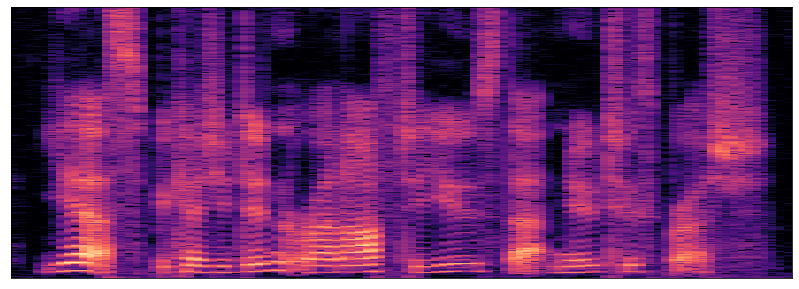

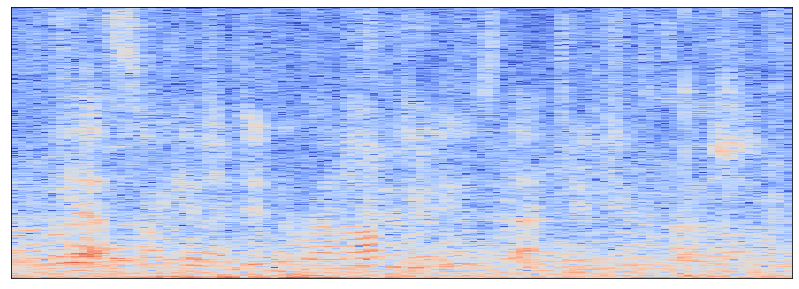

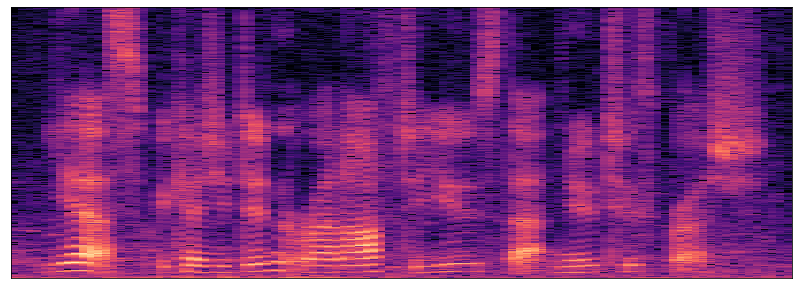

In [ ]:
for x in [clean, noisy_low, noisy_high]:
    plt.figure(figsize=(14, 5))
    s = librosa.stft(x)
    db = librosa.amplitude_to_db(s)
    librosa.display.specshow(db)
    plt.grid()
    plt.show()

Убедитесь, что низким значениям SNR соответствуют спектрограммы, похожие на шум, в то время как для значений в диапазоне 15-20, изменения выглядят не так существенно. 

Эксперименты подтвердили теоретические представления.

## 9.2 Pytorch Datasets (2 балла)
### Train Dataset
Будем генерировать датасеты на лету, при этом тут есть подводный камень. Так как сегменты очень маленькие, то считывать файл с шумом и речью для каждого такого сегмента бессмысленно, поэтому будем считывать по целой аудиозаписи и на каждой итерации генерировать несколько сегментов для обучения.

Но в такой ситуации, чтобы случайно не переполнить память, ограничим количество сегментов в одной аудиозаписи.

In [ ]:
def collate_segments(inputs):
    """
    Performs batch creation from list of source signals.

    Parameters
    ----------
    inputs : tuple of list of tensors
        Input 1d arrays.

    Returns
    -------
    Tuple with clear and noised audios.

    """

    output = list(zip(*inputs))
    noisy = output[0]
    clear = output[1]

    noisy = torch.cat(noisy)
    clear = torch.cat(clear)

    return noisy, clear


class FastSegmentDataset(Dataset):
    def __init__(self, clean_paths, noise_paths, segment_length=1024, 
                 max_num_segments=80, snr_range=(0, 10)):

        self.max_num_segments = max_num_segments
        self.segment_length = segment_length
        self.clean_paths = clean_paths
        self.noise_paths = noise_paths
        self.snr_range = snr_range

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, item):

        clean, _ = librosa.load(self.clean_paths[item], sr=SR)
        random_item = np.random.randint(len(self.noise_paths)-1)
        noise, _ = librosa.load(self.noise_paths[random_item], sr=SR)

        snr = np.random.choice(self.snr_range, 1)
        noise = noise[:len(clean)]
        noisy = add_noise(clean, noise, snr)

        clean = torch.tensor(clean)
        noisy = torch.tensor(noisy)
        clean = torch.cat(list(torch.split(clean, self.segment_length))[:self.max_num_segments])
        noisy = torch.cat(list(torch.split(noisy, self.segment_length))[:self.max_num_segments])

        return noisy, clean

In [ ]:
batch_size = 1
train_dataset = FastSegmentDataset(timit_train_paths, demand_paths)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_segments, batch_size=batch_size)

In [ ]:
noisy, clean = train_dataset[0]
noisy.shape, clean.shape

(torch.Size([46797]), torch.Size([46797]))

In [ ]:
noisy, clean = next(iter(train_dataloader))
noisy.shape, clean.shape

(torch.Size([46797]), torch.Size([46797]))

### Test Dataset

Для тестирования хотим использовать датасет, которые выдает целые аудиозаписи, так как интересует улучшение качества на полных записях, а не очень маленьких фрагментах. 

In [ ]:
class AudioDataset(Dataset):

    def __init__(self, clean_paths, noise_paths, snr_range=(0, 10)):
        self.clean_paths = clean_paths
        self.noise_paths = noise_paths[:len(self.clean_paths)]
        self.snr_range = snr_range

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, item):
        clean, _ = librosa.load(self.clean_paths[item], sr=SR)

        random_item = np.random.randint(len(self.noise_paths)-1)
        noise, _ = librosa.load(self.noise_paths[random_item], sr=SR)

        snr = np.random.choice(self.snr_range, 1)
        noise = noise[:len(clean)]
        noisy = add_noise(clean, noise, snr)

        clean = torch.tensor(clean)
        noisy = torch.tensor(noisy)
        return noisy, clean

In [ ]:
test_dataset = AudioDataset(timit_train_paths, demand_paths)
noisy, clean = test_dataset[0]
noisy.shape, clean.shape

(torch.Size([46797]), torch.Size([46797]))

## 9.3 Model RHRNet (7 баллов)

Теперь реализуем модель. 

У модели должен быть реализован метод **infer**, который получает предсказания для одной полной аудиозаписи. При этом стоит ограничить количество подаваемых в батч сегментов, так как может переполняться память.

В рамках основной части реализуйте метод, который запускает модель на последовательных кусочках без пересечения. 

Архитектура модели

<img src="https://github.com/CODEJIN/RHRNet/raw/main/Figures/Structure.svg" width="1000">

Ниже приведена функция, которая разбивает входной массив на сегменты с заданным шагом и длиной сегменты и склеивает результаты после преобразования.

Класс Transform может быть полезен при реализации метода **infer**.

In [ ]:
from torch.nn.functional import pad

class Pad1D:
    def __init__(self, before, after):
        self.before = before
        self.after = after

    def pad(self, x):
        return pad(x, (self.before, self.after), mode="constant", value=0.0)

    def unpad(self, x):
        if self.after > 0:
            return x[self.before:-self.after]
        else:
            return x[self.before:]


class Transform:
    def __init__(self, stride, segment_length, input_shape):

        self.segment_length = segment_length
        self.stride = stride

        stride_pad = stride * math.ceil(input_shape[-1] / self.stride) - input_shape[-1]
        self.pad_input = Pad1D(0, stride_pad)

        self.overlap_margin = segment_length - stride
        self.pad_window = Pad1D(self.overlap_margin, self.overlap_margin)

        stride = (1, stride)
        unfold_kernel = (1, segment_length)
        fold_kernel = (1, segment_length)

        final_size = (1, input_shape[-1] + stride_pad + 2 * self.overlap_margin)
        self.unfold = nn.Unfold(stride=stride, kernel_size=unfold_kernel)
        self.fold = nn.Fold(output_size=final_size, kernel_size=fold_kernel, stride=stride)
        self.shape = input_shape

    def process(self, x):
        x = x.view(-1)
        x = self.pad_input.pad(x)
        x = self.pad_window.pad(x)
        x = x.view(1, 1, 1, -1)
        x = self.unfold(x).permute(2, 0, 1)
        return x

    def unprocess(self, x):
        x = x.permute(1, 2, 0)
        x = self.fold(x)[0, 0, 0]
        if self.overlap_margin > 0:
            x = x[self.overlap_margin:-self.overlap_margin]
        x = self.pad_input.unpad(x)
        x = x.view(self.shape)
        return x

In [ ]:
x = torch.ones(1000)
transform = Transform(64, 64, x.shape)
print(transform.process(x).shape)
assert (transform.unprocess(transform.process(x)) == x).min()

torch.Size([16, 1, 64])


In [ ]:
class RHRNet(nn.Module):
    """
    RHR-Net: A Residual Hourglass Recurrent Neural Network for Speech Enhancement.

    Parameters
    ----------
    time_sizes : tuple of int,  optional (default=(1024, 512, 256, 128, 256, 512, 1024))
        Time dimension of the rnn layers.
    num_hidden : tuple of int, optional (default=(1, 64, 128, 256, 128, 64, 1))
        Number of hidden units in the rnn layers.
    num_input : tuple of int, optional (default=(1, 4, 256, 512, 256, 128, 64))
        Input sizes for the rnn layers.
    residuals : tuple of int, optional (default=(0, 1, 1, 0, -1, -1, 0))
        Contains values {-1, 0, 1}: 1 if a residual connection starts in the layer,
        -1 if a residual connection ends in the layer, 0 else.
    """

    def __init__(self, time_sizes=(1024, 512, 256, 128, 256, 512, 1024),
                 num_hidden=(1, 64, 128, 256, 128, 64, 1),
                 num_input=(1, 4, 256, 512, 256, 128, 64),
                 residuals=(0, 1, 1, 0, -1, -1, 0)
                 ):
        super(RHRNet, self).__init__()

        self.layer_Dict = torch.nn.ModuleDict()
        self.time_sizes = time_sizes
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.residuals = residuals

        for index in range(len(self.num_hidden)):
            bidirectional = True if index != len(self.time_sizes)-1 else False
            self.layer_Dict['GRU_{}'.format(index)] = torch.nn.GRU(
                input_size = self.num_input[index],
                hidden_size = self.num_hidden[index],
                num_layers = 1,
                batch_first = True,
                bidirectional = bidirectional
                )
            if self.residuals[index] == -1:
                self.layer_Dict['PReLU_{}'.format(index)] = torch.nn.PReLU()

    def forward(self, x):
        x = x.float()

        stacks = []
        start_inds = []
        for index in range(len(self.time_sizes)):
            x = x.reshape(x.size(0), torch.tensor(self.time_sizes[index]), torch.tensor(self.num_input[index]))
            if self.residuals[index] == 1:    # Remember start indexes of residual connections.
                start_inds.append(index)
            if self.residuals[index] == -1:   # End of residual connections.
                ind = start_inds[-1]          # Take start index for this residual connection.  
                start_inds = start_inds[:-1]

                x = self.layer_Dict['PReLU_{}'.format(index)](x + stacks[ind].reshape(x.shape))

            x = self.layer_Dict['GRU_{}'.format(index)](x)[0]
            stacks.append(x)

        return x

    def infer(self, x, mode="separate", infer_batch_size=256):
        transform = Transform(infer_batch_size, 1024, x.shape)
        x = transform.process(x)
        x = torch.transpose(x, 1, 2)
        output = model(x)
        output = torch.transpose(output, 1, 2)
        return transform.unprocess(output)

In [ ]:
noisy, clean = next(iter(train_dataloader))
noisy.shape, clean.shape

(torch.Size([46797]), torch.Size([46797]))

In [ ]:
device = "cuda"
noisy, clean = noisy.to(device), clean.to(device)

In [ ]:
model = RHRNet().to(device)

In [ ]:
# Transform input into correct shape.
transform = Transform(256, 1024, noisy.shape)
noisy = transform.process(noisy)
noisy = torch.transpose(noisy, 1, 2)

# Make prediction.
out = model(noisy)
out = torch.transpose(out, 1, 2)
transform.unprocess(out)

tensor([-0.4689, -0.5004, -0.6208,  ..., -0.6332, -0.5995, -0.5153],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
noisy, clean = test_dataset[0]
noisy, clean = noisy.to(device), clean.to(device)
output = model.infer(noisy)
assert output.shape == noisy.shape

## 9.4 Loss Function (1 балл)

Оригинальная статья использует **LogCosh** функцию потерь. Соответственно в работе также предлагается использовать данную функцию потерь. 

$$
 \mathcal{L}(X, \hat{X}) = \frac{1}{n} \sum \limits_{i=1}^{n} \log \cosh (\mathbf{x_i} - \mathbf{\hat{x}}_i)
$$

In [ ]:
class LogCoshLoss(nn.Module):
    """Log Cosh Loss."""

    def __init__(self):
        super().__init__()

    def forward(self, clean, denoised):
        loss_l1 = nn.L1Loss()
        loss = torch.mean(torch.log(torch.cosh(clean - denoised))) + loss_l1(clean, denoised)

        return loss

Модель может не обучаться с данной функцией потерь из-за неудачно подобранных параметров обучения. В таком случае советую использовать **$L_1$ - loss**.

## 9.5 Обучение модели (3 балла)

Воспользуемся функциями с предыдущих семинаров для обучения модели. 

Добавим возможность подсчета двух метрик одновременно.

In [ ]:
from tqdm import tqdm

class EmptyContext:
    def __enter__(self):
        pass
    def __exit__(self, type, value, traceback):
        pass

def perform_epoch(model, loader, criterion, metric_snr=None, metric_pesq=None,
                optimizer=None, device=None, scheduler=None, 
                max_grad_norm=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_metric_snr = 0
    total_metric_pesq = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_train, batch_answers in tqdm(loader):
            batch_train = batch_train.to(device)
            batch_answers = batch_answers.to(device)

            # Transform input into correct shape.
            transform = Transform(256, 1024, batch_train.shape)
            batch_train = transform.process(batch_train)
            batch_train = torch.transpose(batch_train, 1, 2)
            model_answers = model(batch_train)
            model_answers = torch.transpose(model_answers, 1, 2)
            model_answers = transform.unprocess(model_answers).to(device)

            new_loss = criterion(model_answers, batch_answers)
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              
              if max_grad_norm is not None:
                clip_grad_norm_(model.parameters(), max_grad_norm)
              optimizer.step() 
              if scheduler is not None:
                scheduler.step()

            one_batch_loss = float(criterion(model_answers, batch_answers))
            total_loss += one_batch_loss

            if metric_snr is not None:
              one_batch_metric = metric_snr(model_answers, batch_answers)
              total_metric_snr += one_batch_metric

            if metric_pesq is not None:

              # Avoid zeros (don't get Null in pesq metric).
              model_answers[model_answers==0] = EPS
              batch_answers[batch_answers==0] = EPS
              one_batch_metric = metric_pesq(model_answers.cpu(), batch_answers.cpu())
              total_metric_pesq += one_batch_metric
            total_n += 1 

            del batch_train, batch_answers, model_answers

    if metric_snr is not None and metric_pesq is not None:
        return (total_loss / total_n, total_metric_snr / total_n, total_metric_pesq / total_n)
    elif metric_snr is None and metric_pesq is not None:
        return (total_loss / total_n, total_metric_pesq / total_n)
    elif metric_snr is not None and metric_pesq is None:
        return (total_loss / total_n, total_metric_snr / total_n)
    else:
        return total_loss / total_n

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_grad_norm = 5
lr = 1e-3
decay_rate = 1e-6
momentum = 0.9
num_epoches = 15

In [ ]:
model = RHRNet()
loss_function = LogCoshLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(len(train_dataset)/batch_size + 1)*num_epoches)

In [ ]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_segments, batch_size=1)

Модель обучается достаточно долго, поэтому, если осталось совсем мало времени, обучите одну эпоху и проделайте оставшиеся шаги.

Так как Colab отваливается периодически и заканчиваемся время на использование GPU, я сохраняла модель после каждой эпохи и потом подтягивала веса.

In [ ]:
# Load state dict from previous epochs.

from copy import copy
model.load_state_dict(copy(torch.load('/content/gdrive/MyDrive/' + '/checkpoint_15.pth')))

<All keys matched successfully>

In [ ]:
data_root = '/content/gdrive/MyDrive/'

In [ ]:
for epoch in range(num_epoches):
    loss = perform_epoch(model, train_dataloader, loss_function, 
                         optimizer=optimizer, device=device, 
                         max_grad_norm=max_grad_norm)
    
    print(f"Epoch - {epoch} : loss {loss}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    torch.save(model.state_dict(), data_root + f'/checkpoint_{epoch + 1}.pth')

## 9.6 Метрики (3 балла)

Посчитаем для всех тестовых аудиозаписей значения метрик **[PESQ](https://en.wikipedia.org/wiki/Perceptual_Evaluation_of_Speech_Quality)** и **[SNR](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)**. Так как реализовать PESQ нетривиально, предлагается использовать функцию из библиотеки **pypesq**.

In [ ]:
!pip install pypesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84269 sha256=edf2696356714970b68c8d2235070e44bedb687224a8ab727823acb3a2b2cbac
  Stored in directory: /root/.cache/pip/wheels/48/b5/16/d9a8d51220781689bf670dfcb9ccfdabf45ef26168b052b139
Successfully built pypesq


In [ ]:
from pypesq import pesq

In [ ]:
def snr_score(clear, denoised, eps=1e-20):

    noise = clear - denoised
    snr = (torch.sum(clear ** 2, dim=-1) + eps) / (torch.sum(noise ** 2, dim=-1) + eps)
    snr = 10 * torch.log10(snr)

    return snr

Необходимо:
- посчитать среднее значение метрик на тестовом датасете
- отобразить спектры для нескольких примеров
- сделать выводы о том, как работает модель

In [ ]:
test_dataloader = DataLoader(test_dataset, collate_fn=collate_segments, batch_size=3)

In [ ]:
loss, snr_metric, pesq_metric = perform_epoch(model, test_dataloader, loss_function, device=device, metric_snr=snr_score, metric_pesq=pesq)

100%|██████████| 1540/1540 [26:52<00:00,  1.05s/it]


In [ ]:
print(f'Loss: {loss}, SNR: {snr_metric}, PESQ: {pesq_metric}')

Loss: 0.0045568081845118145, SNR: 5.972557067871094, PESQ: 2.183015579062623


In [ ]:
def specshow(i):
    noisy, clean = test_dataset[i]
    noisy, clean = noisy.to(device), clean.to(device)
    output = model.infer(noisy)

    for x in [noisy, clean, output]:
        x_ = x.cpu().detach().numpy()
        plt.figure(figsize=(14, 5))
        s = librosa.stft(x_)
        db = librosa.amplitude_to_db(s)
        librosa.display.specshow(db)
        plt.grid()
        plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


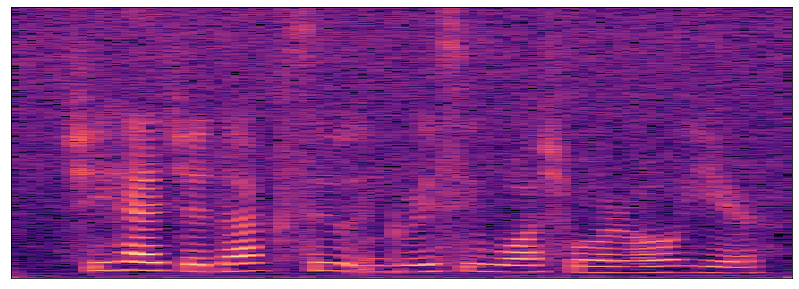

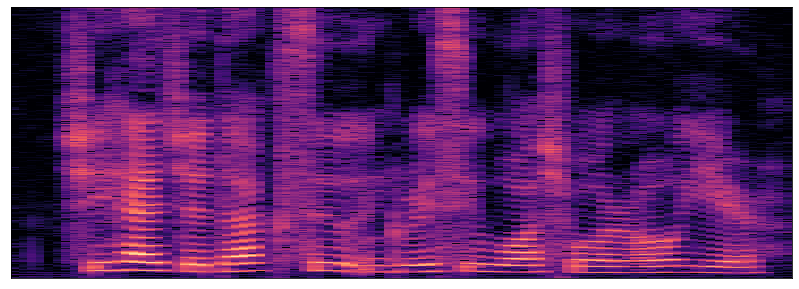

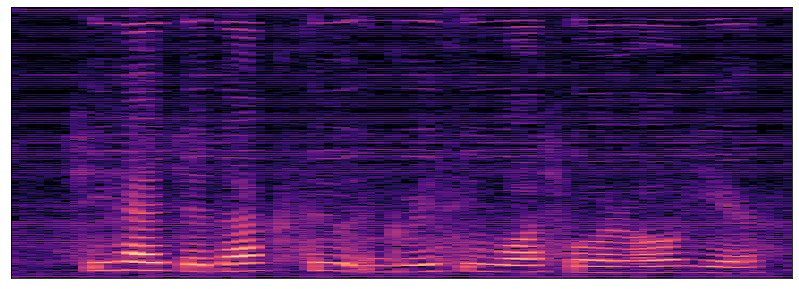

In [ ]:
specshow(0)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


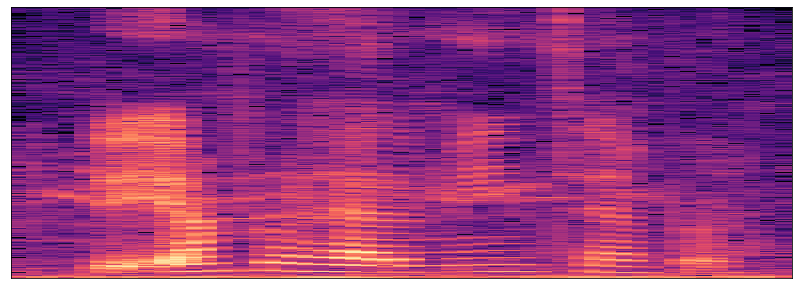

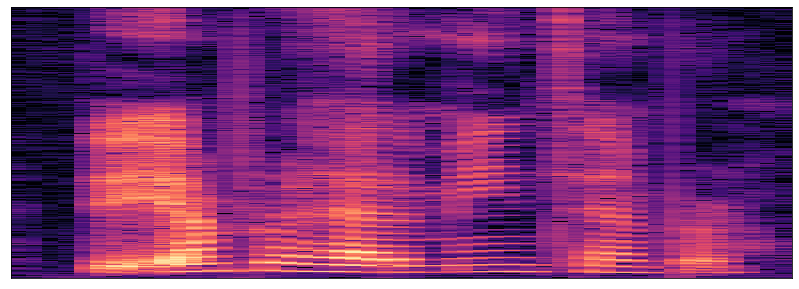

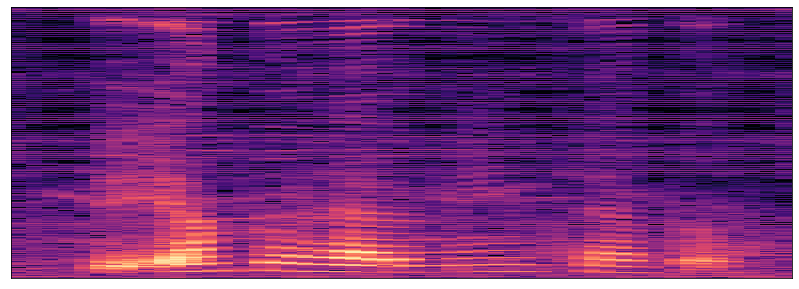

In [ ]:
specshow(1)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


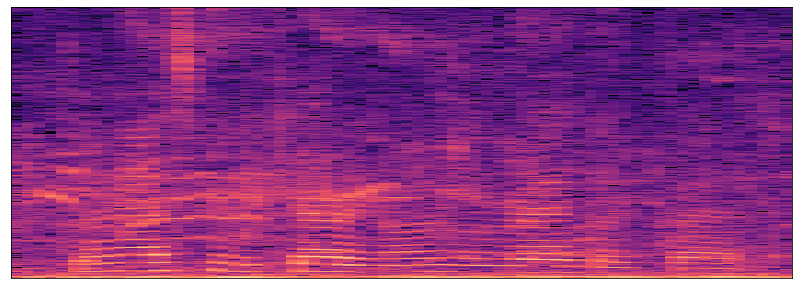

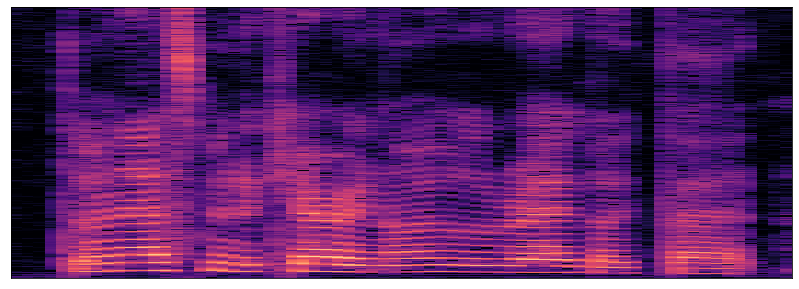

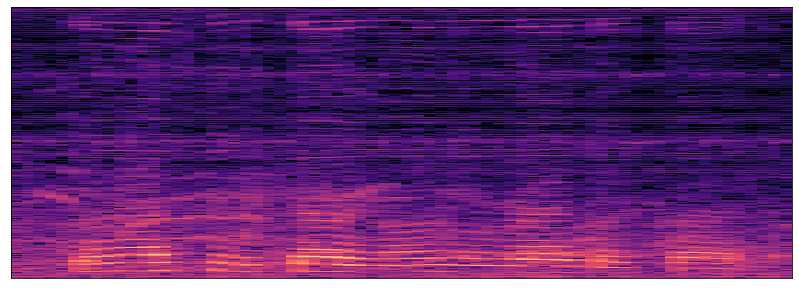

In [ ]:
specshow(2)

По трем спектограммам: шумный сигнал, чистый и выход модели - можно сделать визуальный вывод, что модель справляется с задачей очистки шума, хоть и не очень успешно (недостаточно эпох обучения, от эпохи к эпохе становилось лучше).

# Выводы:    
- Модель обучается долго. Удалось провести 15 эпох обучения.

- Значения метрик в ходе обучения от эпохи к эпохи свидетельствовали об успешном обучении. Конечные значения метрик (SNR = 5.97, PESQ = 2.18) говорят о том, что в полученном результате сигнал доминирует над шумом. Хитрая метрика PESQ (что-то вроде предсказания воспринятого качества сигнала) показывает среднее значение (идеально - 5).

- Было сложно, но очень интересно:) 